This tutorial reproduces the results of Tutorial 18 on spinw.org. It is the spin wave spectrum of the distorted kagome KCu3As2O7(OD)3. The exchange parameters were obtained from "G. J. Nilsen, et al., PRB 89, 140412 (2014)". This is an incommensurate system and therefore single Q calculation methods has been used here to obtain the dispersion. A monte carlo cooldown is performed to ensure that the ground state is indeed a singleQ state.

Get Packages and necessary files

In [12]:
using Sunny, CairoMakie, LinearAlgebra, Revise, FileIO
using Optim , Optimization
includet("DispersionAndIntensitiesDipoleSingleQ.jl")
includet("SWTSingleQcalculations.jl")

Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. The space group is C 2/m or 12. Note that a specific setting needs to be provided for Sunny to correctly recognize the system. There are two symmetry inequivalent CU atoms. Use "types" to break the symmetry between these two. Sunny uses the space group to generate rest of all symmetry equivalent atoms. 

In [13]:
a = 10.2
b = 5.94
c = 7.81
latvecs = lattice_vectors(a, b, c, 90, 117.7, 90)
positions = [[0, 0, 0],[1/4, 1/4, 0]]
types = ["Cu1","Cu2"]
cryst = Crystal(latvecs,positions,12;types,setting="b1")
view_crystal(cryst)
print_symmetry_table(cryst,8)
sys = System(cryst,(1,1,1),[SpinInfo(1,S=1/2,g=2), SpinInfo(3,S=1/2,g=2)], :dipole,seed =0)

Atom 1
Type 'Cu1', position [0, 0, 0], multiplicity 2
Allowed g-tensor: [  A 0 D-E
                     0 B   0
                   D+E 0   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,0] + c₂*𝒪[2,1] + c₃*𝒪[2,2] +
    c₄*𝒪[4,0] + c₅*𝒪[4,1] + c₆*𝒪[4,2] + c₇*𝒪[4,3] + c₈*𝒪[4,4] +
    c₉*𝒪[6,0] + c₁₀*𝒪[6,1] + c₁₁*𝒪[6,2] + c₁₂*𝒪[6,3] + c₁₃*𝒪[6,4] + c₁₄*𝒪[6,5] + c₁₅*𝒪[6,6]

Atom 3
Type 'Cu2', position [1/4, 1/4, 0], multiplicity 4
Allowed g-tensor: [  A F+I E-H
                   F-I   B D+G
                   E+H D-G   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]

Bond(1, 3, [0, 0, 0])
Distance 2.9508854603322, coordination 4


Distance 7.6679040782658, coordination 2
Connects 'Cu2' at [3/4, 1/4, 0] to 'Cu2' at [5/4, 3/4, 1]
Allowed exchange matrix: [A F E
                          F B D
                          E D C]

Bond(1, 4, [0, 0, 0])
Distance 7.7927995611333, coordination 4 (from atom 1) and 2 (from atom 4)
Connects 'Cu1' at [0, 0, 0] to 'Cu2' at [3/4, 1/4, 0]
Allowed exchange matrix: [  A F+I E-H
                          F-I   B D+G
                          E+H D-G   C]
Allowed DM vector: [G H I]

Bond(1, 1, [0, 0, 1])
Distance 7.81, coordination 2
Connects 'Cu1' at [0, 0, 0] to 'Cu1' at [0, 0, 1]
Allowed exchange matrix: [A 0 D
                          0 B 0
                          D 0 C]

Bond(3, 3, [0, 0, 1])
Distance 7.81, coordination 2
Connects 'Cu2' at [1/4, 1/4, 0] to 'Cu2' at [1/4, 1/4, 1]
Allowed exchange matrix: [A F E
                          F B D
                          E D C]

Bond(3, 4, [0, 1, 0])
Distance 7.8290229275434, coordination 4
Connects 'Cu2' at [1/4, 1/4, 0] to 'C

System [Dipole mode]
Lattice (1×1×1)×6
Energy per site 0


Set up the exchanges and the Hamiltonian. Special care must be taken when assigning the exchange values to bonds. The problem arises due to the difference in indexing between Spinw and Sunny. Its possible that some bonds are of the same length and yet are symmetry inequivalent. Values for parameters can be obtained from the paper.

In [14]:
J   = -2;
Jp  = -1;
Jab = 0.75;
Ja  = -J/.66 - Jab;
Jip = 0.01;
set_exchange!(sys,J,Bond(1, 3, [0, 0, 0]))
set_exchange!(sys,Jp,Bond(3, 5, [0, 0, 0]))
set_exchange!(sys,Ja,Bond(3, 4, [0, 0, 0]))
set_exchange!(sys,Jab, Bond(1, 2, [0,0,0]))
set_exchange!(sys,Jip,Bond(3, 4, [0, 0, 1]))

Since single Q method has beem used here, optimization algorithms have been used to determine the k vector.

In [15]:
n = [0.0,0.0,1]
#Sunny.check_rotational_symmetry(sys; n, θ=0.01)
randomize_spins!(sys)
#       Phi1   Phi2  Phi3  k_x  k_y   k_z
xmin = [-1e-6 -1e-6 -1e-6 -1e-6 -1e-6 -1e-6 -1e-6 -1e-6 -1e-6] # Minimum value of x
xmax = [2π 2π 2π 2π 2π 2π 1 1 1]  # Maximum value of x
x0 = [3.2 0.4 3.2 1 1.7 4.1 0.23 0.9 0.799]  # Initial value of x
k = optimagstr(x->gm_planar!(sys,n,x),xmin,xmax,x0)
#-0.7833838383838384

Ground state Energy(meV) = -4.70030303030303


3-element Vector{Float64}:
 0.21409750557743354
 0.9999999950578572
 0.892951251131129

Set up the LSWT object and a path to calculate the dispersion and the intensity bands. Note that to calculate dispersion and intensity, different functions have been used as compared to supercell method.

In [16]:
q_points=[[0,0,0],[1,0,0]]
density = 200
path, xticks = reciprocal_space_path(cryst, q_points, density);
swt = SpinWaveTheory(sys)
formula = Sunny.intensity_formula_SingleQ(swt,k,n, :perp; kernel=delta_function_kernel)
disp, intensity = Sunny.intensities_bands_SingleQ(swt, path, formula);

Plot the dispersion and convoluted powder spectra

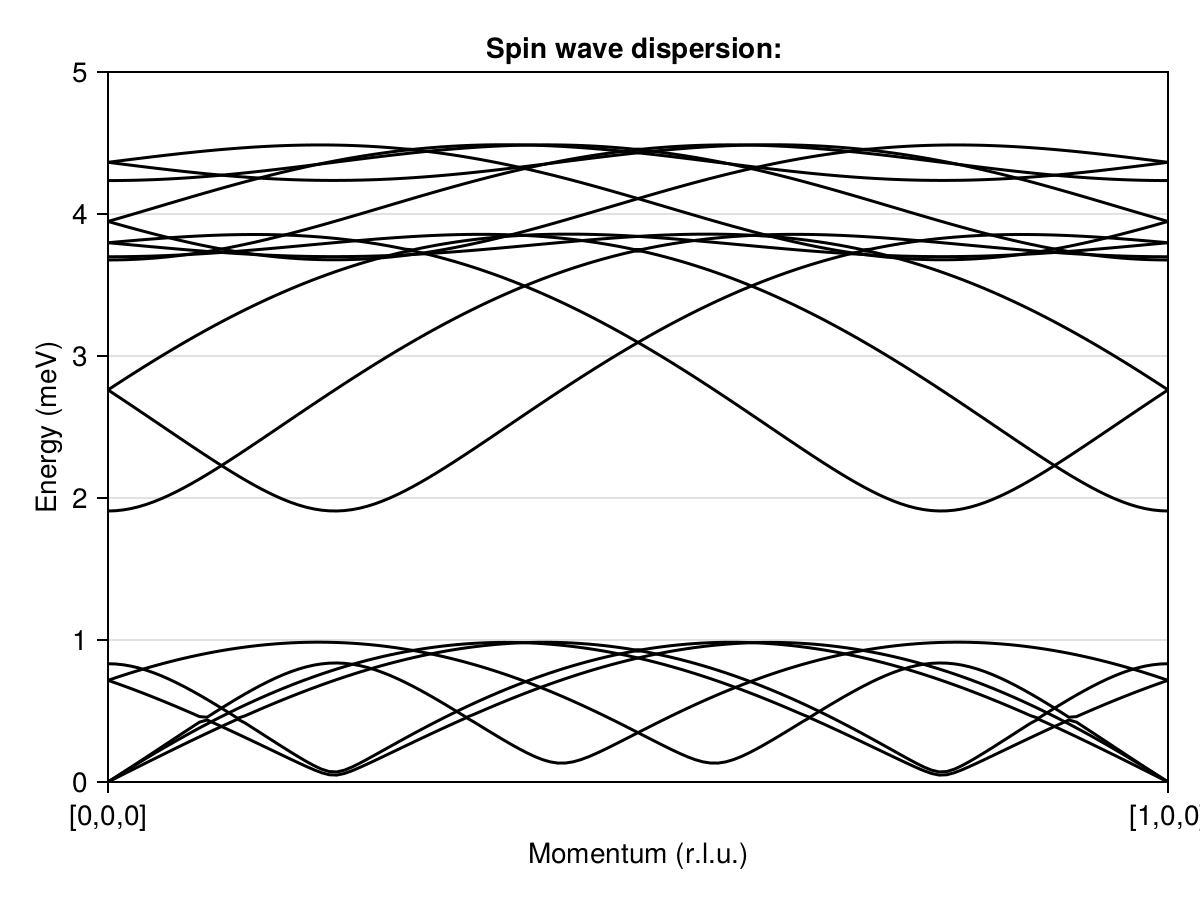

In [17]:
γ = 0.01
energies = collect(0:0.01:5.5)
broadened_formula = Sunny.intensity_formula_SingleQ(swt,k,n, :perp; kernel=lorentzian(γ),formfactors=nothing)
is = Sunny.intensities_broadened_SingleQ(swt, path, energies, broadened_formula);


CairoMakie.activate!
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", title="Spin wave dispersion: ", xticks)
ylims!(ax, 0, 5)
xlims!(ax, 1, size(disp, 1))
for i in axes(disp, 2)
    lines!(ax, 1:length(disp[:,i]), disp[:,i];color="black",colorrange = (0,0.03))
end
fig

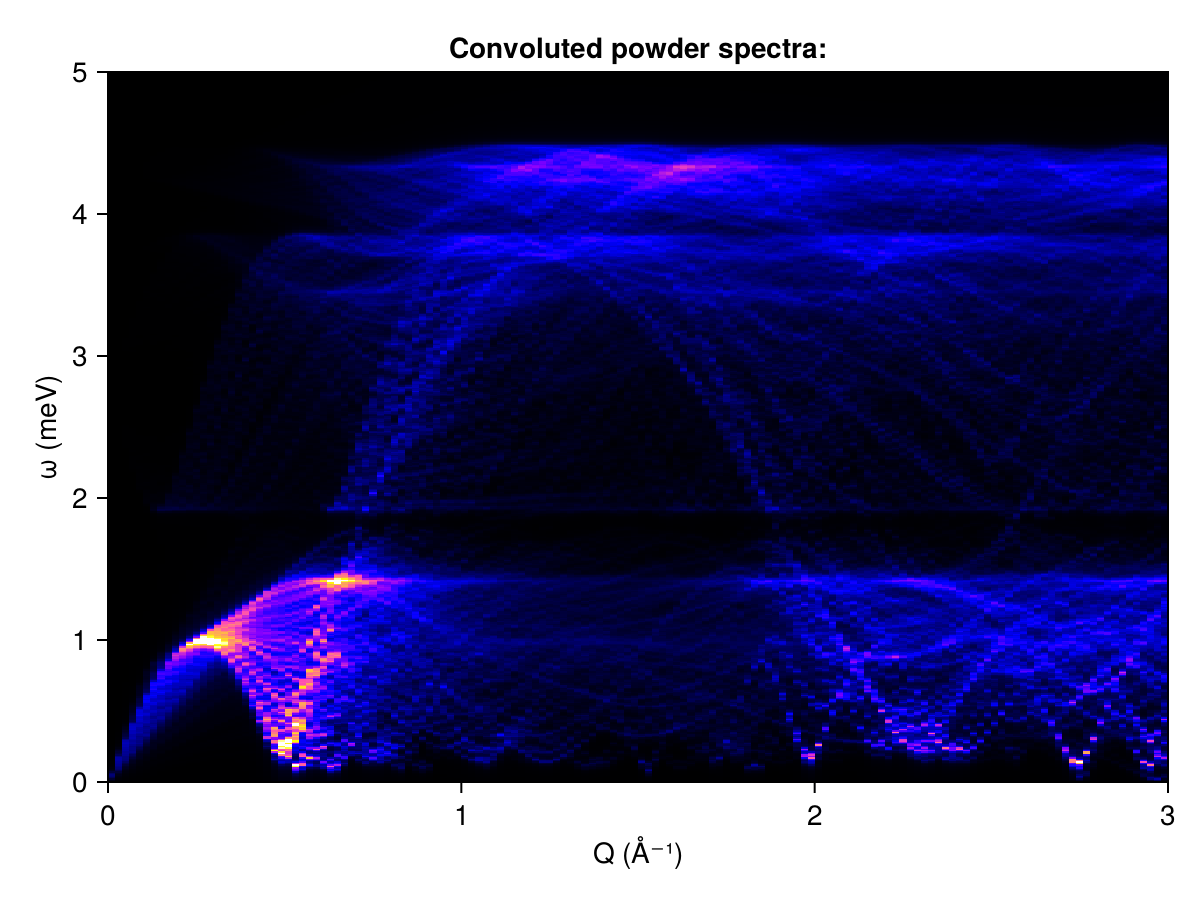

In [19]:

radii = 0.01:0.02:3 
output = zeros(Float64, length(radii), length(energies))
for (i, radius) in enumerate(radii)
    n = 300
    qs = reciprocal_space_shell(cryst, radius, n)
    is1 = Sunny.intensities_broadened_SingleQ(swt, qs, energies, broadened_formula);
    is2=dropdims(sum(is1[:,:,:,:],dims=[3,4]),dims=(3,4))
    output[i, :] = sum(is2, dims=1) / size(is2, 1)
end

fig = Figure()
ax = Axis(fig[1,1]; xlabel="Q (Å⁻¹)", ylabel="ω (meV)",title="Convoluted powder spectra:")
ylims!(ax, 0.0, 5)
heatmap!(ax, radii, energies, output, colormap=:gnuplot2,colorrange=(0.0,1))
fig

Now let's try to obtain the results using luttinger tisza method.

In [10]:
n = [0.0,0.0,1]
randomize_spins!(sys)
k = Sunny.optimize_luttinger_tisza_exchange(sys,[0.21,1.0,0.89])

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  3.970729872577581e-9
 -5.110972468571165e-11
  2.4798419457795307e-9

So luttinger method gives us a commensurate k value, which is different from what was obtained using singleQ method. Now lets obtain the minimum energy eigen value.

In [11]:
Sunny.luttinger_tisza_exchange(sys, k)
Sunny.minimize_energy_spiral!(sys,k, n)


┌ Error: Spiral exchange energy -4.040303030303031 exceeds L.T. exchange energy -4.935454545454547, which suggests instability.
└ @ Sunny /Users/bhushanthipe/.julia/packages/Sunny/Kmqzx/src/SpinWaveTheory/SingleQ.jl:178


-4.040303030303031

We can see that the luttinger tisza energy is lower than the energy obtained using singleQ. So this should be the ground state right? But as we will see the LSWT object is not stable.

In [12]:
q_points=[[0,0,0],[1,0,0]]
density = 200
path, xticks = reciprocal_space_path(cryst, q_points, density);
swt = SpinWaveTheory(sys)
formula = Sunny.intensity_formula_SingleQ(swt,k,n, :perp; kernel=delta_function_kernel)
disp, intensity = Sunny.intensities_bands_SingleQ(swt, path, formula);

ErrorException: Instability at wavevector q = [0.0, 0.0, 0.0]

There is instability. Whats happening? We have assumed it to be a spiral structure  We have a lower energy eigen value, but its unstable whereas the slightly higher ground state is stable. What Luttinger tisza does is it minimizes the classical energy of the system subject to the strong condition (conservation of spin length on each site). Here, although the eigen energy is lower, it is not able to satisfy the strong condition and hence the lswt object is unstable.So is the singleQ ground state correct or is it getting stuck in some local minima around which it is able to perform LSWT? What is really the ground state?  We perform a monte carlo cooldown to actually determine this. We set up a large supercell and exchanges and perform the cooldown from 100 K to 0.1 K.

In [74]:
sys = System(cryst,(25,5,10),[SpinInfo(1,S=1/2,g=2), SpinInfo(3,S=1/2,g=2)], :dipole,seed =0)


J   = -2;
Jp  = -1;
Jab = 0.75;
Ja  = -J/.66 - Jab;
Jip = 0.01;
set_exchange!(sys,J,Bond(1, 3, [0, 0, 0]))
set_exchange!(sys,Jp,Bond(3, 5, [0, 0, 0]))
set_exchange!(sys,Ja,Bond(3, 4, [0, 0, 0]))
set_exchange!(sys, Jab, Bond(1, 2, [0,0,0]))
set_exchange!(sys,Jip,Bond(3, 4, [0, 0, 1]))
randomize_spins!(sys)

n_step = 1000
Δt=0.05
kT_Ks = 10 .^ range(log10(100),log10(0.1),100)
for kT_K in kT_Ks
    kT=kT_K*Sunny.meV_per_K
    λ=0.1
    langevin = Langevin(Δt; λ, kT)
    for _ in 1:n_step
        Sunny.step!(sys,langevin)
    end
end


print_wrapped_intensities(sys)

Dominant wavevectors for spin sublattices:

    [-1/5, 0, 1/10]        47.50% weight
    [1/5, 0, -1/10]        47.50%
    [1/5, 0, 0]             0.26%
    [-1/5, 0, 0]            0.26%
    [-0.24, 0, 1/10]        0.17%
    [0.24, 0, -1/10]        0.17%
    [-0.24, 0, 1/5]         0.13%
    [0.24, 0, -1/5]         0.13%
    [0.24, 0, 0]            0.12%
    [-0.24, 0, 0]           0.12%
    [-1/5, 0, 1/5]          0.11%
    ...                     ...


It can be seen that there are two dominant wavevectors. Further minimization of energy of the system will eliminate the non dominant vectors.



In [76]:
minimize_energy!(sys;maxiters=30000)

2458

In [77]:
print_wrapped_intensities(sys)

Dominant wavevectors for spin sublattices:

    [-1/5, 0, 1/10]        50.00% weight
    [1/5, 0, -1/10]        50.00%


As can be seen, the system has contribution from only two vectors, which are opposites of each other. Therefore, indeed the ground state of the system is a singleQ state.